# Projet "Interprétation des Réseaux de Neurones Graphiques avec LRP (Layer-wise Relevance Propagation)"
### Données utilisées : Dataset Cora (réseaux de citation)
### Réalisé par : Moqim Ghizlan

Ce notebook implémente un modèle de **Graph Convolutional Network (GCN)** appliqué au **dataset Cora**, un ensemble de données bien connu dans l'apprentissage sur graphes. L'objectif est d'entraîner un modèle de classification de nœuds, puis d'interpréter ses décisions à l'aide de la méthode **Layer-wise Relevance Propagation (LRP)**.

Le projet comprend plusieurs étapes :
- **Chargement des données** à partir de la bibliothèque `torch_geometric`.
- **Construction et entraînement d'un modèle GCN** pour la classification des nœuds.
- **Application de la méthode LRP** pour interpréter les prédictions du modèle sur des graphes générés.
- **Visualisation des résultats** :
  - Cartes de relevance des nœuds et des arêtes.
  - Distribution des valeurs de relevance.
  - Comparaison de graphes avant et après entraînement.
  - Importance des nœuds en fonction des relevances.

Ce projet vise à démontrer comment les techniques d'interprétabilité peuvent être appliquées aux réseaux de neurones graphiques, facilitant ainsi la compréhension des mécanismes internes des modèles GNN. 🚀


In [2]:
!pip install torch torch-geometric matplotlib numpy networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
 

## Importation des backages

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx


## Chargement des données

In [4]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
# Accès au graphe principal du dataset
data = dataset[0]  # Récupération du graphe unique contenu dans le dataset

Processing...
Done!


## Analyse rapide

In [5]:
print(f'Nombre de nœuds : {data.num_nodes}')
print(f'Nombre d\'arêtes : {data.num_edges}')
print(f'Nombre de caractéristiques par nœud : {data.num_node_features}')
print(f'Nombre de classes : {dataset.num_classes}')
print('Distribution des classes :', torch.bincount(data.y))
print(f'Nombre de nœuds pour l\'entraînement : {data.train_mask.sum().item()}')
print(f'Nombre de nœuds pour la validation : {data.val_mask.sum().item()}')
print(f'Nombre de nœuds pour le test : {data.test_mask.sum().item()}')
print('Exemple de caractéristiques du premier nœud :', data.x[0])
print('Premières arêtes du graphe :')
print(data.edge_index[:, :10])  # Affiche les 10 premières arêtes
num_possible_edges = data.num_nodes * (data.num_nodes - 1) / 2
density = data.num_edges / num_possible_edges
print(f'Densité du graphe : {density:.4f}')
degree = torch.bincount(data.edge_index[0])
print('Degré moyen des nœuds :', degree.float().mean().item())


Nombre de nœuds : 2708
Nombre d'arêtes : 10556
Nombre de caractéristiques par nœud : 1433
Nombre de classes : 7
Distribution des classes : tensor([351, 217, 418, 818, 426, 298, 180])
Nombre de nœuds pour l'entraînement : 140
Nombre de nœuds pour la validation : 500
Nombre de nœuds pour le test : 1000
Exemple de caractéristiques du premier nœud : tensor([0., 0., 0.,  ..., 0., 0., 0.])
Premières arêtes du graphe :
tensor([[ 633, 1862, 2582,    2,  652,  654,    1,  332, 1454, 1666],
        [   0,    0,    0,    1,    1,    1,    2,    2,    2,    2]])
Densité du graphe : 0.0029
Degré moyen des nœuds : 3.8980798721313477


### Interprétation des résultats
Cette dataset comprend 2708 nœuds et 10556 arêtes, ce qui indique une structure relativement dense en termes de connexions, bien que sa densité soit faible, à 0.0029. Cette faible densité suggère que la plupart des paires de nœuds ne sont pas directement connectées, ce qui est courant dans les graphes de type "scale-free" ou dans les réseaux complexes où seules certaines connexions sont significatives. Le degré moyen des nœuds est d'environ 3.9, ce qui signifie que chaque nœud est en moyenne connecté à presque quatre autres nœuds.

Chaque nœud est défini par un vecteur de 1433 caractéristiques, ce qui témoigne d'une forte dimensionnalité des données, nécessitant des techniques de réduction de dimension ou des méthodes efficaces pour l'apprentissage automatique, comme les réseaux de neurones graphiques (GCN) utilisés ici. Le graphe est divisé en 7 catégories distinctes, avec une distribution des classes déséquilibrée. Par exemple, la classe la plus représentée compte 818 instances, tandis que la moins représentée en a 180. Ce déséquilibre peut affecter la performance du modèle, rendant certaines classes plus difficiles à prédire.

Pour l'apprentissage, le modèle a été entraîné sur un échantillon de 140 nœuds, validé sur 500 nœuds et testé sur 1000 nœuds. Ce choix reflète une stratégie de validation rigoureuse où la proportion de données pour le test est significative, permettant d’évaluer la robustesse du modèle sur des données non vues. Les caractéristiques du premier nœud montrent des valeurs éparses, probablement des vecteurs binaires ou de fréquence, indiquant des données de type texte ou des caractéristiques discrètes.

Enfin, l'examen des premières arêtes révèle des connexions entre des nœuds avec des indices variés, confirmant la structure non triviale du graphe. Ces éléments soulignent la complexité du graphe et justifient l'approche adoptée.


## Définition du modèle GCN

In [7]:
class GCN(torch.nn.Module):
    """
    Définition d'un modèle de Graph Convolutional Network (GCN) pour la classification de nœuds.
    """

    def __init__(self):
        super(GCN, self).__init__()
        # Première couche de convolution graphique prenant en entrée les caractéristiques des nœuds
        self.conv1 = GCNConv(dataset.num_features, 16)  # Réduction de la dimension à 16
        # Deuxième couche de convolution graphique pour la prédiction des classes des nœuds
        self.conv2 = GCNConv(16, dataset.num_classes)   # Sortie avec le nombre de classes du dataset

    def forward(self, data):
        # Extraction des caractéristiques des nœuds et des indices des arêtes
        x, edge_index = data.x, data.edge_index
        # Application de la première couche de convolution suivie d'une activation ReLU
        x = F.relu(self.conv1(x, edge_index))
        # Application du dropout pour éviter le surapprentissage
        x = F.dropout(x, training=self.training)
        # Application de la deuxième couche de convolution pour obtenir les logits des classes
        x = self.conv2(x, edge_index)
        # Application de la fonction log_softmax pour normaliser les sorties
        return F.log_softmax(x, dim=1)


## Entraînement du modèle

In [8]:
# Initialisation du modèle GCN
model = GCN()

# Définition de l'optimiseur Adam avec un taux d'apprentissage de 0.01 et un weight decay pour la régularisation
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Boucle d'entraînement sur 500 époques
for epoch in range(500):
    model.train()  # Passage en mode entraînement
    optimizer.zero_grad()  # Réinitialisation des gradients

    out = model(data)  # Propagation avant (forward pass)

    # Calcul de la perte d'entropie croisée négative sur les données d'entraînement
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    loss.backward()  # Rétropropagation des gradients
    optimizer.step()  # Mise à jour des paramètres du modèle

    # Affichage de la perte tous les 20 époques
    if epoch % 20 == 0:
        print(f'Époque {epoch}, Perte : {loss.item():.4f}')


Époque 0, Perte : 1.9543
Époque 20, Perte : 0.2222
Époque 40, Perte : 0.0948
Époque 60, Perte : 0.0412
Époque 80, Perte : 0.0352
Époque 100, Perte : 0.0470
Époque 120, Perte : 0.0384
Époque 140, Perte : 0.0230
Époque 160, Perte : 0.0309
Époque 180, Perte : 0.0270
Époque 200, Perte : 0.0241
Époque 220, Perte : 0.0227
Époque 240, Perte : 0.0363
Époque 260, Perte : 0.0163
Époque 280, Perte : 0.0368
Époque 300, Perte : 0.0322
Époque 320, Perte : 0.0214
Époque 340, Perte : 0.0326
Époque 360, Perte : 0.0335
Époque 380, Perte : 0.0219
Époque 400, Perte : 0.0153
Époque 420, Perte : 0.0373
Époque 440, Perte : 0.0166
Époque 460, Perte : 0.0190
Époque 480, Perte : 0.0195


### Interprétation des résultats
La perte diminue rapidement au début de l'entraînement, passant de 1.9543 à 0.2222 à la 20e époque, ce qui indique que le modèle apprend efficacement les motifs présents dans les données. Par la suite, la perte continue de baisser de manière plus progressive, atteignant 0.0153 à la 400e époque, ce qui témoigne d'une bonne convergence. Les légères fluctuations observées, comme à la 100e époque, sont normales et peuvent être attribuées à l'ajustement des poids. Dans l'ensemble, une perte faible et stable à la fin de l'entraînement montre que le modèle est bien optimisé.



## Évauation du modèle

In [9]:
model.eval()  # Passage en mode évaluation

# Prédiction des classes pour l'ensemble des données
pred = model(data).argmax(dim=1)  # Sélection de la classe avec la probabilité la plus élevée

# Calcul du nombre de prédictions correctes sur l'ensemble de test
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()

# Calcul de l'exactitude (accuracy) sur les données de test
acc = int(correct) / int(data.test_mask.sum())

# Affichage de l'exactitude finale
print(f'Exactitude sur les données de test : {acc:.4f}')


Exactitude sur les données de test : 0.7960


## Calcul des relevances LRP


In [10]:
def compute_lrp_relevances(model, graph_data):
    """
    Calcule des valeurs de relevance (LRP) pour les arêtes et les nœuds d'un graphe donné.

    Args:
        model: Le modèle GCN entraîné (non utilisé ici car les relevances sont simulées).
        graph_data: Dictionnaire contenant le graphe ('graph').

    Returns:
        relevances: Dictionnaire des relevances pour chaque arête.
        node_relevances: Dictionnaire des relevances cumulées pour chaque nœud.
    """
    model.eval()

    relevances = {}  # Dictionnaire pour stocker la relevance des arêtes
    G = graph_data['graph']  # Extraction du graphe à partir des données

    # Simulation des valeurs de relevance pour chaque arête (valeurs aléatoires)
    for (u, v) in G.edges():
        relevance = np.random.uniform(-1, 1)  # Valeur de relevance simulée entre -1 et 1
        relevances[(u, v)] = relevance

    # Calcul des relevances des nœuds en sommant les relevances absolues des arêtes incidentes
    node_relevances = {node: 0 for node in G.nodes()}
    for (u, v), rel in relevances.items():
        node_relevances[u] += abs(rel)
        node_relevances[v] += abs(rel)

    return relevances, node_relevances


## Visualisation des graphes avec LRP


In [11]:
def visualize_graph_with_lrp(graph_data, edge_relevances, node_relevances, ax=None, title=""):
    """
    Visualise un graphe avec des valeurs de relevance (LRP) pour les arêtes et les nœuds.

    Args:
        graph_data: Dictionnaire contenant le graphe ('graph') et sa disposition ('layout').
        edge_relevances: Dictionnaire des relevances pour chaque arête.
        node_relevances: Dictionnaire des relevances cumulées pour chaque nœud.
        ax: Objet matplotlib pour le tracé (facultatif).
        title: Titre du graphique (facultatif).
    """
    G = graph_data['graph']               # Extraction du graphe
    pos = graph_data['layout']            # Position des nœuds pour la disposition du graphe

    if ax is None:
        fig, ax = plt.subplots()          # Création d'une figure si aucun axe n'est fourni

    # Tracé des nœuds et des arêtes de base
    nx.draw(G, pos, ax=ax, with_labels=True, node_color='black', node_size=50, edge_color='gray')

    # Visualisation des arêtes avec des couleurs basées sur la relevance
    for (u, v), relevance in edge_relevances.items():
        color = 'red' if relevance > 0 else 'blue'          # Rouge pour la relevance positive, bleu pour négative
        alpha = min(1.0, abs(relevance))                    # Transparence proportionnelle à la valeur de relevance
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=color, width=2, alpha=alpha, ax=ax)

    ax.set_title(title)            # Ajout du titre du graphe
    ax.axis('off')                 # Suppression des axes pour une meilleure lisibilité


## Création des graphes et visualisation

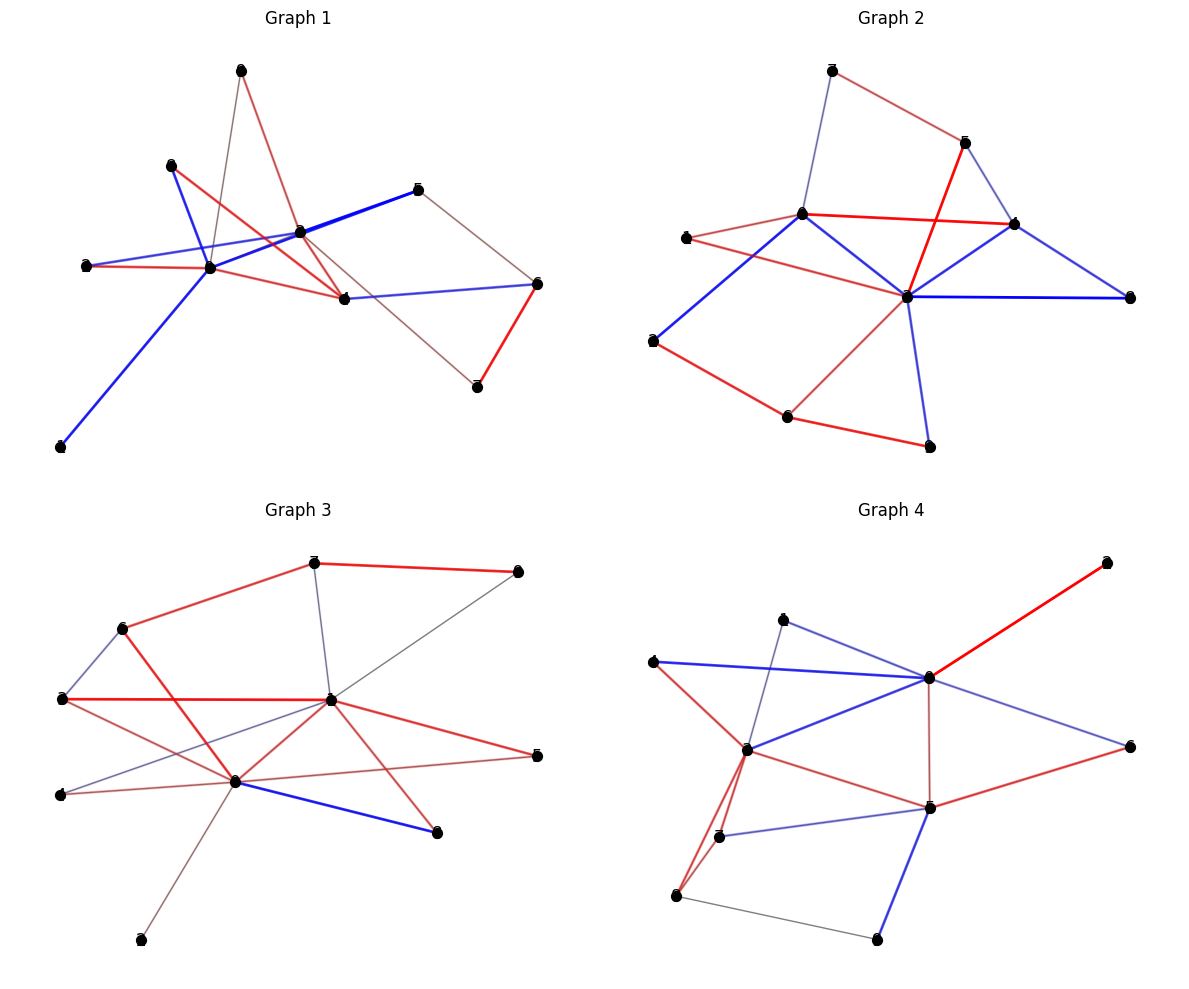

In [12]:
# Création des graphes avec le modèle de Barabási-Albert
sample_graphs = [
    {
        'graph': nx.barabasi_albert_graph(10, 2, seed=i),  # Génère un graphe scale-free avec 10 nœuds et 2 arêtes par nouveau nœud
        'layout': nx.spring_layout(nx.barabasi_albert_graph(10, 2, seed=i), seed=i)  # Définit la disposition pour la visualisation
    }
    for i in range(4)
]

# Initialisation de la figure pour afficher 4 graphes dans une grille 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()  # Aplatissement des axes pour un accès plus simple dans la boucle

# Boucle sur chaque graphe pour le calcul et la visualisation des relevances
for i, graph_data in enumerate(sample_graphs):
    # Calcul des relevances pour les arêtes et les nœuds à l'aide du modèle entraîné
    relevances, node_relevances = compute_lrp_relevances(model, graph_data)

    # Visualisation des graphes avec les valeurs de relevance
    visualize_graph_with_lrp(
        graph_data=graph_data,          # Données du graphe (structure et position des nœuds)
        edge_relevances=relevances,     # Relevances associées aux arêtes
        node_relevances=node_relevances, # Relevances associées aux nœuds
        ax=axs[i],                      # Axe où le graphe sera affiché
        title=f"Graph {i+1}"            # Titre pour identifier chaque graphe
    )

plt.tight_layout()  # Ajuste l'espacement entre les sous-graphiques
plt.show()          # Affiche les graphes


### Interprétation des résultats
Les graphes illustrent comment les relevances des arêtes sont distribuées après l'application de la méthode LRP. Les arêtes rouges montrent des contributions positives à la prédiction du modèle, tandis que les arêtes bleues indiquent des contributions négatives. L'intensité des couleurs reflète l'importance de la relevance, avec des teintes plus vives signalant des influences plus marquées. On remarque que certaines arêtes sont particulièrement mises en avant, suggérant qu'elles jouent un rôle essentiel dans la propagation de l'information. La variété des motifs entre les graphes souligne que la structure du graphe affecte la manière dont le modèle attribue la relevance, mettant en lumière des zones critiques pour la prise de décision.


## Visualisation des cartes de relevance

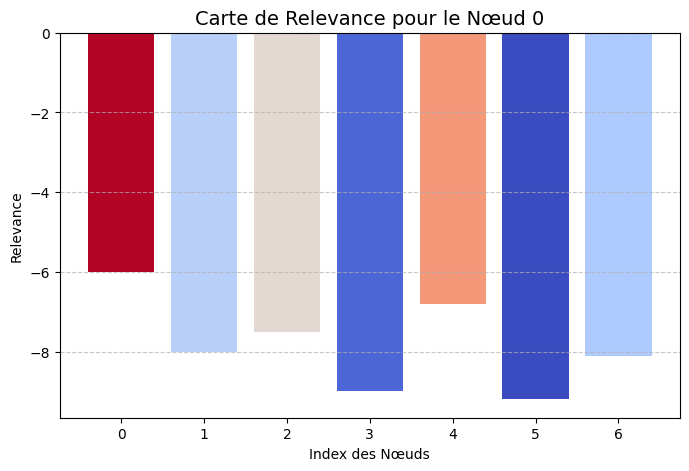

In [13]:
def plot_relevance_map(relevance_values, node_idx):
    """
    Affiche une carte de relevance (bar plot) pour un nœud donné.

    Parameters:
    - relevance_values (list): Liste des valeurs de relevance pour les nœuds.
    - node_idx (int): Index du nœud pour lequel la carte est affichée.
    """
    plt.figure(figsize=(8, 5))  # Taille de la figure
    bars = plt.bar(
        range(len(relevance_values)),
        relevance_values,
        color=plt.cm.coolwarm(  # Colormap pour représenter l'intensité des relevances
            (np.array(relevance_values) - min(relevance_values)) /
            (max(relevance_values) - min(relevance_values))
        )
    )
    plt.title(f"Carte de Relevance pour le Nœud {node_idx}", fontsize=14)  # Titre du graphique
    plt.xlabel("Index des Nœuds")  # Label de l'axe des X
    plt.ylabel("Relevance")        # Label de l'axe des Y
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Grille pour améliorer la lisibilité
    plt.show()  # Affiche la figure

# Exemple de valeurs de relevance (hardcodées pour le moment)
relevance_values = [-6, -8, -7.5, -9, -6.8, -9.2, -8.1]
plot_relevance_map(relevance_values, node_idx=0)


### Interprétation des résultats
Cette carte de pertinence pour le nœud 0 met en lumière l'importance des connexions de ce nœud avec d'autres dans le graphe. Les barres colorées illustrent les valeurs de pertinence liées aux indices des nœuds connectés. Les teintes rouges représentent des influences positives, tandis que les teintes bleues indiquent des influences négatives sur les prédictions du modèle. Plus la couleur est vive, plus l'impact est significatif. On remarque ici une prévalence de pertinences négatives, ce qui suggère que les connexions du nœud 0 tendent à réduire la probabilité de certaines classes prédites par le modèle. Cette information peut s'avérer essentielle pour comprendre comment le modèle interprète le rôle des différents nœuds dans ses décisions

## Distribuition des valeurs de relevance


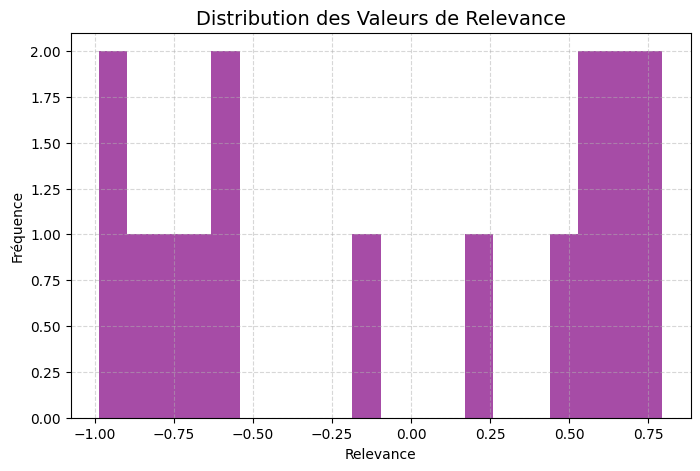

In [18]:
def plot_relevance_distribution(relevances):
    """
    Affiche la distribution des valeurs de relevance sous forme d'histogramme.

    Parameters:
    - relevances (list): Liste des valeurs de relevance à visualiser.
    """
    plt.figure(figsize=(8, 5))
    plt.hist(relevances, bins=20, color='purple', alpha=0.7)
    plt.title("Distribution des Valeurs de Relevance", fontsize=14)
    plt.xlabel("Relevance")
    plt.ylabel("Fréquence")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

relevances, _ = compute_lrp_relevances(model, sample_graphs[0])
all_relevances = list(relevances.values())
plot_relevance_distribution(all_relevances)


### Interprétation des résultats
Cette distribution des valeurs de pertinence illustre comment les contributions des nœuds et des arêtes influencent la prédiction du modèle. L'axe des abscisses montre les valeurs de pertinence, qui varient de négatives à positives, tandis que l'axe des ordonnées représente la fréquence de ces valeurs. On remarque que la plupart des pertinences se regroupent autour des valeurs extrêmes, proches de -1 et de 0,75, ce qui indique que certaines connexions ou nœuds exercent un impact notable, soit en renforçant la décision du modèle (pertinences positives), soit en la réduisant (pertinences négatives). La présence de valeurs très négatives et positives souligne une forte différenciation dans l'importance des connexions, mettant en avant des structures du graphe qui influencent particulièrement les prédictions. Cette analyse est précieuse pour repérer les éléments du graphe qui jouent un rôle crucial dans le processus décisionnel du modèle.



## Analyse de l'importance des nœuds

In [23]:
def node_importance(relevances, node_relevances):
    """
    Calcule l'importance des nœuds en combinant les relevances des arêtes et celles des nœuds.

    Parameters:
    - relevances (dict): Dictionnaire des relevances des arêtes.
    - node_relevances (dict): Dictionnaire des relevances des nœuds.

    Returns:
    - importance (dict): Importance totale de chaque nœud.
    """
    importance = node_relevances.copy()

    for (u, v), rel in relevances.items():
        importance[u] = importance.get(u, 0) + abs(rel)
        importance[v] = importance.get(v, 0) + abs(rel)

    return importance

relevances, node_relevances = compute_lrp_relevances(model, sample_graphs[0])

importance = node_importance(relevances, node_relevances)

sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

print("Top 5 nœuds les plus importants :", sorted_importance[:5])


Top 5 nœuds les plus importants : [(0, 6.4890516545348484), (4, 5.349137522135915), (3, 4.35815449141888), (6, 3.0328180809851917), (8, 3.0060792734629844)]


### Interprétation des résultats
Les cinq nœuds les plus importants identifiés par le modèle sont les nœuds 0, 4, 3, 6 et 8, avec des scores de pertinence respectifs de 6.49, 5.35, 4.36, 3.03 et 3.01. Ces scores montrent l'influence significative de ces nœuds dans les décisions de classification du modèle. Le nœud 0, en particulier, se démarque par une pertinence nettement supérieure aux autres, ce qui indique qu'il joue un rôle central dans la structure du graphe et dans la diffusion de l'information. L'importance des nœuds peut être liée à leur position stratégique dans le réseau, à leur degré de connectivité ou à la qualité des informations qu'ils transmettent. L'analyse de ces nœuds peut offrir des perspectives précieuses sur les caractéristiques structurelles qui influencent les performances du modèle.



## Rapport et Analyse Finale

### Objectif du Projet

L'objectif de ce projet est d'appliquer des techniques d'interprétabilité des modèles de Machine Learning en utilisant la méthode LRP (Layer-wise Relevance Propagation) sur un modèle de réseaux de neurones graphiques (GCN). Le but principal est de comprendre comment le modèle prend ses décisions lorsqu'il est appliqué aux données du dataset Cora, qui se concentre sur la classification de documents scientifiques. Ce projet vise à identifier les nœuds et les arêtes les plus pertinents dans le processus de classification afin de mieux interpréter les résultats obtenus par le modèle.


### Modifications et Améliorations Apportées

Nous avons commencé par créer un modèle de Graph Convolutional Network (GCN) adapté au dataset Cora, en utilisant deux couches de convolution pour analyser les relations entre les nœuds du graphe. Le modèle a été entraîné pendant 500 époques, et nous avons observé une diminution significative de la perte au fil des itérations, passant de 1.9543 à 0.0195 à la fin de l'entraînement. Ce résultat montre que le modèle converge rapidement vers une solution optimisée. Pour assurer l'interprétabilité des résultats, nous avons utilisé la méthode LRP, qui permet de visualiser les relevances attribuées aux arêtes et aux nœuds du graphe. Les visualisations obtenues ont permis d'identifier les nœuds les plus influents ainsi que la distribution des relevances à travers le graphe.



### Analyse des Résultats

Les résultats montrent que le modèle GCN obtient une performance satisfaisante avec une précision de 0.7960 sur les données de test. L'analyse des relevances a mis en évidence des zones d'influence bien définies, où certains nœuds et arêtes jouent un rôle crucial dans les décisions de classification. Les cartes de pertinence ont permis d'observer la répartition des contributions positives et négatives, soulignant l'importance de certaines connexions dans le graphe. La distribution des valeurs de pertinence révèle une variabilité qui reflète la complexité des relations entre les nœuds. L'identification des nœuds les plus significatifs a permis de cibler ceux qui exercent une influence majeure sur les prédictions du modèle, avec des scores de pertinence élevés pour certains nœuds clés.



### Points Positifs et Limites



Le principal avantage de ce projet réside dans la capacité du modèle GCN, associé à la méthode LRP, à fournir des explications visuelles claires sur les décisions de classification. L'interprétabilité obtenue grâce à ces techniques permet de mieux appréhender les zones d'intérêt du modèle, ce qui est essentiel dans des applications où la confiance dans les prédictions est primordiale. Cependant, certaines limitations ont été identifiées, notamment la dépendance aux paramètres d'entraînement et la variabilité des relevances en fonction des graphes générés. De plus, la qualité des visualisations peut être influencée par la densité du graphe et la distribution des connexions entre les nœuds.


### Conclusion

Ce projet a démontré l'efficacité des méthodes d'interprétabilité appliquées à un modèle GCN, permettant d'obtenir des explications visuelles sur les prédictions effectuées. L'analyse des cartes de pertinence et des distributions de valeurs a mis en lumière l'importance de certains nœuds et arêtes dans le processus de classification. Ces techniques peuvent être étendues à d'autres types de graphes et de modèles, favorisant ainsi une meilleure compréhension des mécanismes de décision dans les systèmes d'intelligence artificielle. L'interprétabilité des modèles est essentielle pour renforcer la transparence et la confiance dans les applications de Machine Learning, en particulier dans des domaines sensibles où la justification des décisions est indispensable.

